<a href="https://colab.research.google.com/github/anaguilarar/CC_Weight_Prediction/blob/main/1_data_extraction_using_bb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Individual plant imagery extraction

In this example, we will use spatial file, containing bounding boxes, to extract UAV-based data. The UAV data sources utilized in this process include RGB orthomosaic, multispectral (MS) orthomosaic, and 3D point cloud data. For each bounding box, we will extract the corresponding information and combine it into a single 4D image representation, encompassing time points, channels, width, and height dimensions.

In [1]:
import os
## clonning repositories
if not os.path.exists("/content/drone_data") and not os.getcwd().endswith("/content/drone_data"):
    !git clone https://github.com/anaguilarar/drone_data.git
    print("Cloned")
    
else:
    print("drone_data directory already exists")

Cloning into 'drone_data'...
remote: Enumerating objects: 1044, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 1044 (delta 26), reused 42 (delta 17), pack-reused 988
Receiving objects: 100% (1044/1044), 17.04 MiB | 14.50 MiB/s, done.
Resolving deltas: 100% (779/779), done.
Cloned


In [2]:
## installing packages
!pip install -r /content/drone_data/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 25.2 MB/s eta 0:00:00



### Data downloading

The data that we will use as an example the information captured on 29th September. Besides, we will also use vector files that indicate the individual plant bounding boxes. This data is storaged in a google drive folder. Thus, the information will be uploaded to the colab storage using the folowing cell.

In [3]:
def download_from_drive(urlid):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(urlid)}).GetList()
  if len(file_list)>0:
    for j in range(len(file_list)):
      linkto = file_list[j]['id']
      file_listsub = drive.ListFile({'q': "'{}' in parents and trashed=false".format(linkto)}).GetList()
      if len(file_listsub)>0:
        foldername = file_list[j]['title']
        if not os.path.exists(foldername):
          os.mkdir(foldername)
        os.chdir(foldername)
        download_from_drive(linkto)
        os.chdir('..')

      else:
        #for i, file in enumerate(sorted(file_list, key = lambda x: x['title']), start=1):
        file = file_list[j]
        print('Downloading {} file from GDrive ({}/{})'.format(file['title'], j+1, len(file_list)))
        file.GetContentFile(file['title'])


In [4]:

from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


spatial_boundaries = '1YjKEgdUJ5edicNMNbevox4rXPPosbPDp'
uavdata = '1vfjRVe-oGlho6qdm01a2B__DK3r77Ba4'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

for linktod in [spatial_boundaries, uavdata]:
  download_from_drive(linktod)
 

'point_cloud'

### Imagery extraction

For this example, we will utilize the "IndividualUAVData" function, which takes directory paths for each multisourcing data as its arguments. The information extraction process will involve using bounding boxes, which are represented in the format of a GeoPandas dataframe.

In [ ]:

#### import drone package
import pickle
import geopandas as gpd
from drone_data.utils.drone_data import DroneData
from drone_data.utils.xyz_functions import CloudPoints
from drone_data.utils.plt_functions import plot_multibands_fromxarray
from drone_data.utils.multipolygons_functions import IndividualUAVData

from drone_data.utils.plt_functions import plot_multichanels
import numpy as np

In [ ]:
#### list images information

RGBFILES = [
	"F:/drone_data/Tanashi_cc_winter_2021/dc_1_20210922/P4rtk_15m_RTK/tana_cc_rgb_210922/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_3_20210929/P4rtk_15m_RTK/tana_cc_rgb_210929/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_4_20211004/P4rtk_15m_RTK/tana_cc_rgb_211004/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_5_20211006/P4rtk_15m_RTK/tana_cc_rgb_211006/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_6_20211008/P4rtk_15m_RTK/tana_cc_rgb_211008/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_7_20211011/P4rtk_15m_RTK/tana_cc_rgb_211011/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_8_20211014/P4rtk_15m_RTK/tana_cc_rgb_211014/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_9_20211018/P4rtk_15m_RTK/tana_cc_rgb_211018/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_10_20211020/P4rtk_15m_RTK/tana_cc_rgb_211020/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_11_20211021/P4rtk_15m_RTK/tana_cc_rgb_211021/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_12_20211025/P4rtk_15m_RTK/tana_cc_rgb_211025/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_13_20211028/P4rtk_15m_RTK/tana_cc_rgb_211028/3_dsm_ortho/2_mosaic/",
	
	"F:/drone_data/Tanashi_cc_winter_2021/dc_14_20211101/P4rtk_15m_RTK/tana_cc_rgb_211101/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_15_20211104/P4rtk_15m_RTK/tana_cc_rgb_211104/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_16_20211105/P4rtk_15m_RTK/tana_cc_rgb_211105/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_17_20211108/P4rtk_15m_RTK/tana_cc_rgb_211108/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_18_20211110/P4rtk_15m_RTK/tana_cc_rgb_211110/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_19_20211112/P4rtk_15m_RTK/tana_cc_rgb_211112/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_20_20211115/P4rtk_15m_RTK/tana_cc_rgb_211115/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_21_20211117/P4rtk_15m_RTK/tana_cc_rgb_211117/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_22_20211119/P4rtk_15m_RTK/tana_cc_rgb_211119/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_23_20211124/P4rtk_15m_RTK/tana_cc_rgb_211124/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_24_20211126/P4rtk_15m_RTK/tana_cc_rgb_211126/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_25_20211129/P4rtk_15m_RTK/tana_cc_rgb_211129/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_26_20211206/P4rtk_15m_RTK/tana_cc_rgb_211206/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_27_20211215/P4rtk_15m_RTK/tana_cc_rgb_211215/3_dsm_ortho/2_mosaic/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_28_20211220/P4rtk_15m_RTK/tana_cc_rgb_211220/3_dsm_ortho/2_mosaic/"]


XYZPATHS = [
	"F:/drone_data/Tanashi_cc_winter_2021/dc_1_20210922/P4rtk_15m_RTK/tana_cc_rgb_210922/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_3_20210929/P4rtk_15m_RTK/tana_cc_rgb_210929/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_4_20211004/P4rtk_15m_RTK/tana_cc_rgb_211004/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_5_20211006/P4rtk_15m_RTK/tana_cc_rgb_211006/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_6_20211008/P4rtk_15m_RTK/tana_cc_rgb_211008/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_7_20211011/P4rtk_15m_RTK/tana_cc_rgb_211011/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_8_20211014/P4rtk_15m_RTK/tana_cc_rgb_211014/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_9_20211018/P4rtk_15m_RTK/tana_cc_rgb_211018/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_10_20211020/P4rtk_15m_RTK/tana_cc_rgb_211020/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_11_20211021/P4rtk_15m_RTK/tana_cc_rgb_211021/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_12_20211025/P4rtk_15m_RTK/tana_cc_rgb_211025/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_13_20211028/P4rtk_15m_RTK/tana_cc_rgb_211028/2_densification/point_cloud/",
	
	"F:/drone_data/Tanashi_cc_winter_2021/dc_14_20211101/P4rtk_15m_RTK/tana_cc_rgb_211101/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_15_20211104/P4rtk_15m_RTK/tana_cc_rgb_211104/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_16_20211105/P4rtk_15m_RTK/tana_cc_rgb_211105/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_17_20211108/P4rtk_15m_RTK/tana_cc_rgb_211108/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_18_20211110/P4rtk_15m_RTK/tana_cc_rgb_211110/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_19_20211112/P4rtk_15m_RTK/tana_cc_rgb_211112/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_20_20211115/P4rtk_15m_RTK/tana_cc_rgb_211115/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_21_20211117/P4rtk_15m_RTK/tana_cc_rgb_211117/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_22_20211119/P4rtk_15m_RTK/tana_cc_rgb_211119/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_23_20211124/P4rtk_15m_RTK/tana_cc_rgb_211124/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_24_20211126/P4rtk_15m_RTK/tana_cc_rgb_211126/2_densification/point_cloud/",		
	"F:/drone_data/Tanashi_cc_winter_2021/dc_25_20211129/P4rtk_15m_RTK/tana_cc_rgb_211129/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_26_20211206/P4rtk_15m_RTK/tana_cc_rgb_211206/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_27_20211215/P4rtk_15m_RTK/tana_cc_rgb_211215/2_densification/point_cloud/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_28_20211220/P4rtk_15m_RTK/tana_cc_rgb_211220/2_densification/point_cloud/"]


MSFILES = [
	"F:/drone_data/Tanashi_cc_winter_2021/dc_1_20210922/P4m_15m_RTK/tana_cc_ms_210922/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_3_20210929/P4m_15m_RTK/tana_cc_ms_210929/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_4_20211004/P4m_15m_RTK/tana_cc_ms_211004/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_5_20211006/P4m_15m_RTK/tana_cc_ms_211006/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_6_20211008/P4m_15m_RTK/tana_cc_ms_211008/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_7_20211011/P4m_15m_RTK/tana_cc_ms_211011/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_8_20211014/P4m_15m_RTK/tana_cc_ms_211014/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_9_20211018/P4m_15m_RTK/tana_cc_ms_211018/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_10_20211020/P4m_15m_RTK/tana_cc_ms_211020/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_11_20211021/P4m_15m_RTK/tana_cc_ms_211021/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_12_20211025/P4m_15m_RTK/tana_cc_ms_211025/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_13_20211028/P4m_15m_RTK/tana_cc_ms_211028/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_14_20211101/P4m_15m_RTK/tana_cc_ms_211101/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_15_20211104/P4m_15m_RTK/tana_cc_ms_211104/4_index/reflectance/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_16_20211105/P4m_15m_RTK/tana_cc_ms_211105/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_17_20211108/P4m_15m_RTK/tana_cc_ms_211108/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_18_20211110/P4m_15m_RTK/tana_cc_ms_211110/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_19_20211112/P4m_15m_RTK/tana_cc_ms_211112/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_20_20211115/P4m_15m_RTK/tana_cc_ms_211115/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_21_20211117/P4m_15m_RTK/tana_cc_ms_211117/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_22_20211119/P4m_15m_RTK/tana_cc_ms_211119/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_23_20211124/P4m_15m_RTK/tana_cc_ms_211124/4_index/reflectance/",
    "F:/drone_data/Tanashi_cc_winter_2021/dc_24_20211126/P4m_15m_RTK/tana_cc_ms_211126/4_index/reflectance/",
	
	"F:/drone_data/Tanashi_cc_winter_2021/dc_25_20211129/P4m_15m_RTK/tana_cc_ms_211129/4_index/reflectance/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_26_20211206/P4m_15m_RTK/tana_cc_ms_211206/4_index/reflectance/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_27_20211215/P4m_15m_RTK/tana_cc_ms_211215/4_index/reflectance/",
	"F:/drone_data/Tanashi_cc_winter_2021/dc_28_20211220/P4m_15m_RTK/tana_cc_ms_211220/4_index/reflectance/"]

bbfile = "F:/OneDrive - The University of Tokyo/drone_data/results/tanashicropdetection/cc_od_polygons_yolodr5m_tana_ov_65conf_mn_tp.shp"
roiorig = gpd.read_file(bbfile)


In [ ]:
import random
from drone_data.utils.xr_functions import stack_as4dxarray
from drone_data.utils.multipolygons_functions import single_vi_bsl_impt_preprocessing
from drone_data.utils.classification_functions import cluster_4dxarray
from drone_data.utils.plt_functions import plot_multitemporal_rgb

from drone_data.utils.data_processing import find_date_instring
from datetime import datetime
import time


capturedates = [find_date_instring(RGBFILES[i]) for i in range(len(RGBFILES))]
datesnames = [datetime.strptime(m,'%Y%m%d') for m in capturedates]

datalist = []

st = time.time()
#j = 5 paper example
j = 0
for i in range(len(RGBFILES)):
    
    uavdata = IndividualUAVData(rgb_input = RGBFILES[i],
                ms_input = MSFILES[i],
                threed_input = XYZPATHS[i],
                spatial_boundaries = roiorig.iloc[j:j+1])

    uavdata.rgb_uavdata()
    print('Execution time RGB:', -st + time.time(), 'seconds')
    uavdata.ms_uavdata()
    print('Execution time MS:', -st + time.time(), 'seconds')
    uavdata.pointcloud(interpolate = True)
    print('Execution time Point Cloud:', -st + time.time(), 'seconds')
    uavdata.stack_uav_data(bufferdef = None, 
        rgb_asreference = True,resample_method = 'nearest')
    datalist.append(uavdata.uav_sources['stacked'])

uavmltdata = stack_as4dxarray(datalist,axis_name = 'date', 
            valuesaxis_names=datesnames, 
            resizeinter_method = 'nearest')

xrexamples = single_vi_bsl_impt_preprocessing(uavmltdata.copy(), 
                vilist=['rgbvi', 'ndvi', 'savi', 'ndre', 'gndvi', "rgbvi_rgb", "rgbvi_eq", "grvi_eq", "grvi_rgb"],
                baseline=True)



Execution time RGB: 0.5116312503814697 seconds
Execution time MS: 0.7450075149536133 seconds
Execution time Point Cloud: 8.630409717559814 seconds
Execution time RGB: 9.176961421966553 seconds
Execution time MS: 9.418304204940796 seconds
Execution time Point Cloud: 16.96688961982727 seconds
Execution time RGB: 17.465556144714355 seconds
Execution time MS: 17.68596649169922 seconds
Execution time Point Cloud: 26.046603679656982 seconds
Execution time RGB: 26.602118253707886 seconds
Execution time MS: 26.89034938812256 seconds
Execution time Point Cloud: 35.17436861991882 seconds
Execution time RGB: 35.669073820114136 seconds
Execution time MS: 35.88048076629639 seconds
Execution time Point Cloud: 44.474751710891724 seconds
Execution time RGB: 44.93153119087219 seconds
Execution time MS: 45.171913146972656 seconds
Execution time Point Cloud: 53.77580904960632 seconds
Execution time RGB: 54.26250767707825 seconds
Execution time MS: 54.47995448112488 seconds
Execution time Point Cloud: 63.

In [ ]:
i = 2
j = 5
uavdata = IndividualUAVData(rgb_input = RGBFILES[i],
                ms_input = MSFILES[i],
                threed_input = XYZPATHS[i],
                spatial_boundaries = roiorig.iloc[j:j+1],buffer=0)

#uavdata.rgb_uavdata()
#print('Execution time RGB:', -st + time.time(), 'seconds')
uavdata.ms_uavdata()
print('Execution time MS:', -st + time.time(), 'seconds')

Execution time MS: 6002.161905050278 seconds


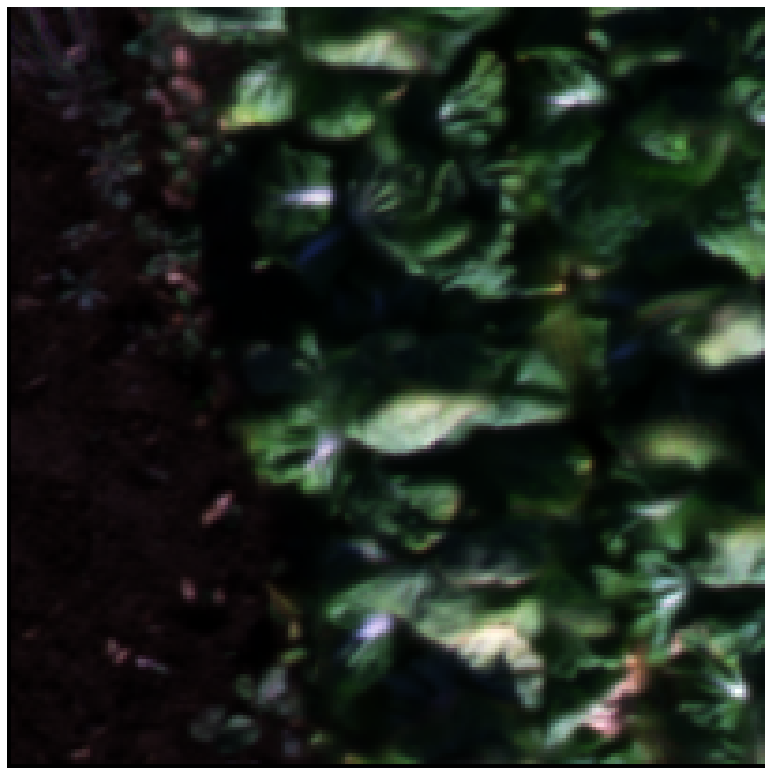

In [ ]:
uavdata.uav_sources['ms'].plot_multiplebands(bands = ['red','green','blue'])

In [ ]:

#uavdata.rgb_uavdata()
#print('Execution time RGB:', -st + time.time(), 'seconds')
uavdata.rgb_uavdata()
print('Execution time RGB:', -st + time.time(), 'seconds')

Execution time RGB: 1995.3103702068329 seconds


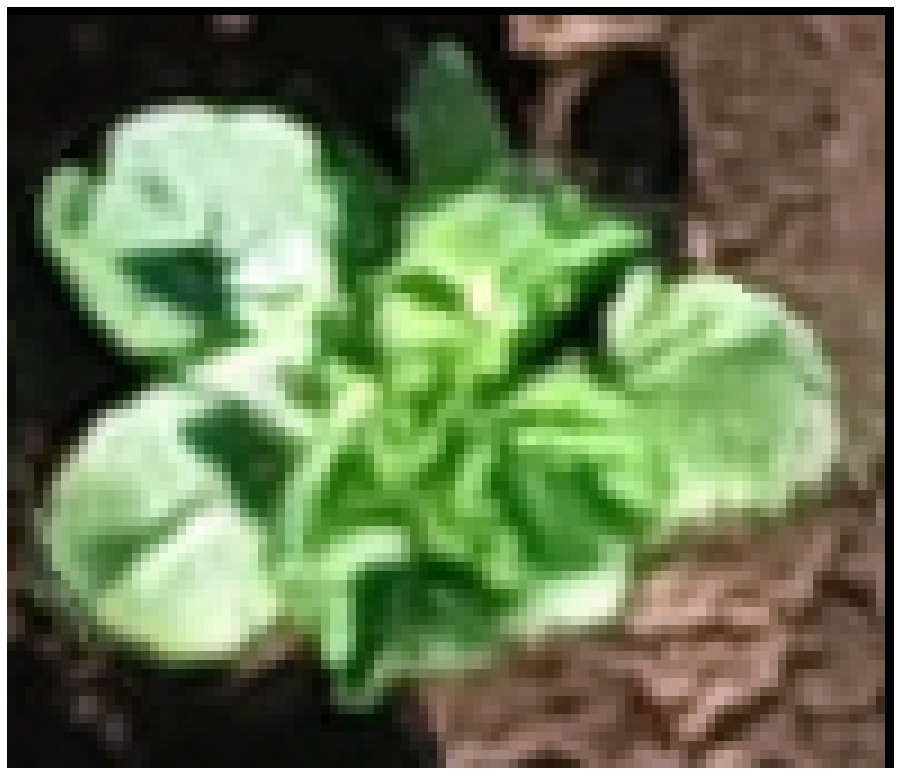

In [ ]:
uavdata.uav_sources['rgb'].plot_multiplebands(bands = ['red','green','blue'])

In [ ]:
uavdata.pointcloud(interpolate = True)
print('Execution time Point Cloud:', -st + time.time(), 'seconds')

Execution time Point Cloud: 2010.0023136138916 seconds


In [ ]:
from drone_data.utils.plt_functions import plot_3d_cloudpoints

plot_3d_cloudpoints(uavdata.uav_sources['pointcloud'].twod_image)

In [ ]:
uavdata.stack_uav_data(bufferdef = None, 
        rgb_asreference = True,resample_method = 'nearest')

<xarray.Dataset>
Dimensions:      (y: 84, x: 98)
Coordinates:
  * y            (y) float64 3.956e+06 3.956e+06 ... 3.956e+06 3.956e+06
  * x            (x) float64 3.681e+05 3.681e+05 ... 3.681e+05 3.681e+05
    spatial_ref  int32 0
Data variables:
    red          (y, x) float64 10.0 11.0 12.0 14.0 ... 98.0 106.0 98.0 94.0
    green        (y, x) float64 10.0 11.0 13.0 14.0 14.0 ... 85.0 93.0 84.0 80.0
    blue         (y, x) float64 9.0 10.0 11.0 13.0 12.0 ... 63.0 71.0 62.0 57.0
    blue_ms      (y, x) float64 0.005742 0.005789 0.005789 ... 0.0 0.0 0.0
    green_ms     (y, x) float64 0.00657 0.006731 0.006731 ... 0.0 0.0 0.0
    red_ms       (y, x) float64 0.00644 0.006402 0.006402 ... 0.0 0.0 0.0
    edge         (y, x) float64 0.01327 0.01328 0.01328 0.01341 ... 0.0 0.0 0.0
    nir          (y, x) float64 0.01935 0.01932 0.01932 0.01869 ... 0.0 0.0 0.0
    z            (y, x) float64 96.38 96.38 96.39 96.39 ... 96.33 96.33 96.33
    red_3d       (y, x) float64 12.47 12.47 12.41 12.41 ... 92.51 92.51 92.51
    green_3d     (y, x) float64 12.61 12.61 12.52 12.52 ... 81.44 81.44 81.44
    blue_3d      (y, x) float64 12.26 12.26 12.31 12.31 ... 60.53 60.53 60.53
Attributes:
    driver:      GTiff
    dtype:       uint8
    nodata:      nan
    width:       98
    height:      84
    count:       12
    crs:         EPSG:32654
    transform:   | 0.00, 0.00, 368134.96|\n| 0.00, 0.00, 3956094.39|\n| 0.00,...
    tiled:       False
    compress:    lzw
    interleave:  pixel

In [ ]:
xrexamples = single_vi_bsl_impt_preprocessing(uavmltdata.copy(), 
                vilist=['rgbvi', 'ndvi', 'savi', 'ndre', 'gndvi', "rgbvi_rgb", "rgbvi_eq", "grvi_eq", "grvi_rgb"],
                baseline=True)


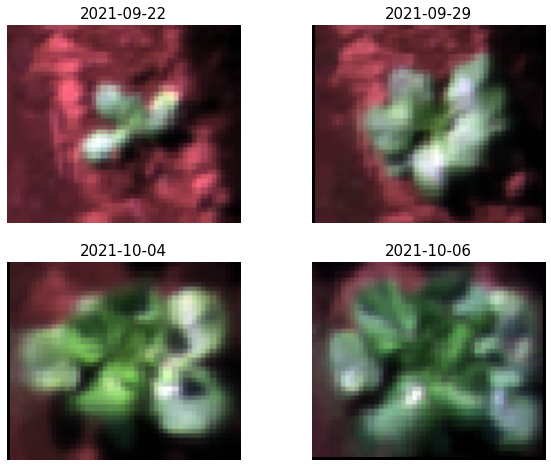

In [ ]:
f1= plot_multitemporal_rgb(xrexamples[0], ncols = 2,nrows = 2, figsize= (10,8), 
                        bands=['red_ms','green_ms','blue_ms'], scale = 'minmax')

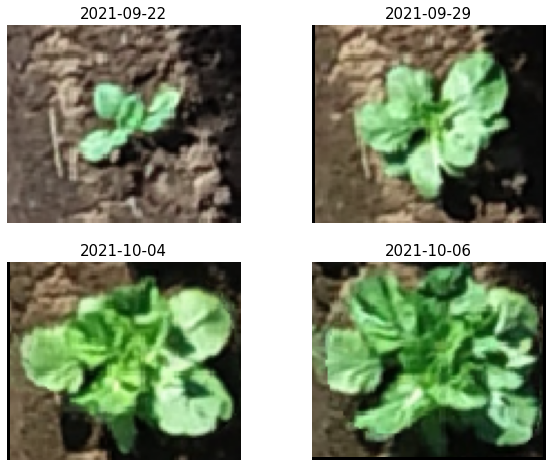

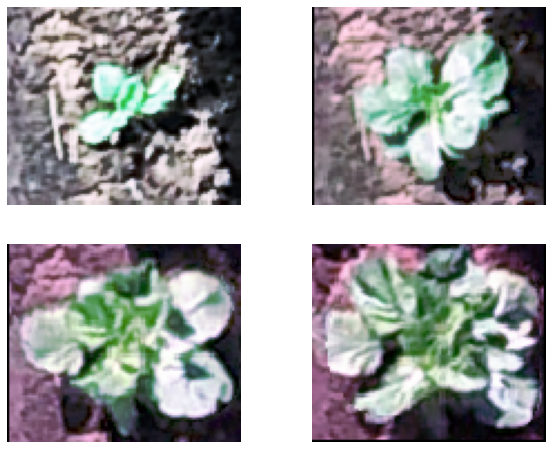

In [ ]:
f1= plot_multitemporal_rgb(xrexamples[0], ncols = 2,nrows = 2, figsize= (10,8))
f2= plot_multitemporal_rgb(xrexamples[0], ncols = 2,nrows = 2, figsize= (10,8), 
                        bands=['red_eq','green_eq','blue_eq'], scale = 'minmax',titlelabel=False)

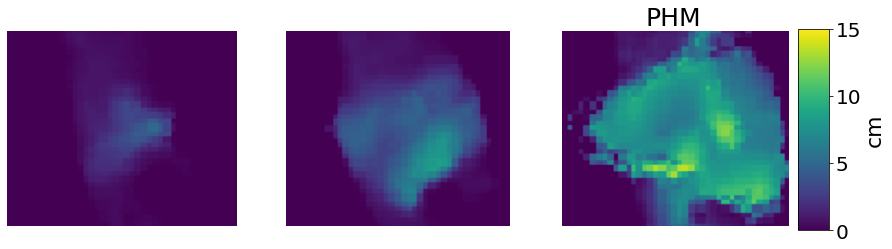

In [ ]:
from drone_data.utils.plt_functions import plot_multichanels

f = plot_multichanels(xrexamples[0].z.values, num_rows=1, num_columns=3, figsize= (14,4),fontsize=25, legtickssize=20,label_name= 'cm',legfontsize=22,vmax=15, chanels_names=['','', 'PHM'])

(<Figure size 720x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'RGBVI_RGB'}>,
        <AxesSubplot:title={'center':'NDVI'}>], dtype=object))

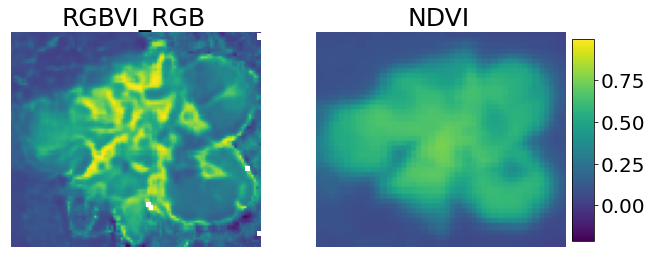

In [ ]:
plot_multichanels(xrexamples[0][['rgbvi_rgb','savi']].isel(date = 2).to_array().values, num_rows=1, num_columns=2, figsize= (10,4), chanels_names=['RGBVI_RGB','NDVI','SAVI'],fontsize=25, legtickssize=20)